# Craft a Story from a Dataset

The purpose of this case study is to visualize the progression of the pandemic over the course of the past year.

Datasets utilized:

- Admin 0 - Countries dataset from Natural Earth
http://www.naturalearthdata.com/downloads/10m-cultural-vectors/

- Coronavirus (COVID-19) Cases
https://ourworldindata.org/covid-cases


We start by importing relevant packages:

    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('covid_data.csv')
df.shape

(78664, 59)

Since I am predominantly interested in total_cases in countries over time, I subset the dataset to contain only a few of the rows in the initial file, and grouping by date and location.


In [4]:
subset1 = df[['total_cases', 'total_deaths', 'date', 'location']]

test1 = subset1.groupby(['date', 'location']).sum()

test1.reset_index()

test1.head()

total_cases  total_deaths
date       location                            
2020-01-01 Argentina          0.0           0.0
           Mexico             0.0           0.0
2020-01-02 Argentina          0.0           0.0
           Mexico             0.0           0.0
2020-01-03 Argentina          0.0           0.0

Creation of a pivot_table allows for a new dataframe that indexed by date and each column is a different country.

We can then subset the columns of the 10 largest most populous countries in the world.

In [5]:
table = pd.pivot_table(test1, values='total_cases', index='date',
                    columns=['location'], aggfunc=np.sum)

countries = pd.DataFrame(table)

countries.head()


location,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,World,Yemen,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now I'm just selecting the world's 10 top most populous countries.



In [6]:
countries = countries[['China', 'India', 'United States', 'Indonesia', 'Pakistan', 'Brazil', 'Nigeria', 'Bangladesh', 'Russia', 'Mexico']]

### Visualizing trends


This is a plot of the total daily cases for the top 10 most populous countries in the world.

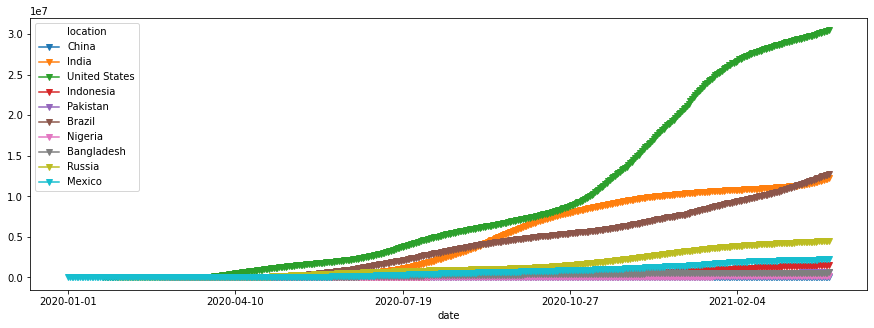

In [7]:
countries.plot(marker="v",figsize=(15,5))

This plot also shows daily cases, but resamples by month

In [11]:
countries = countries.set_index(pd.to_datetime(countries.index))


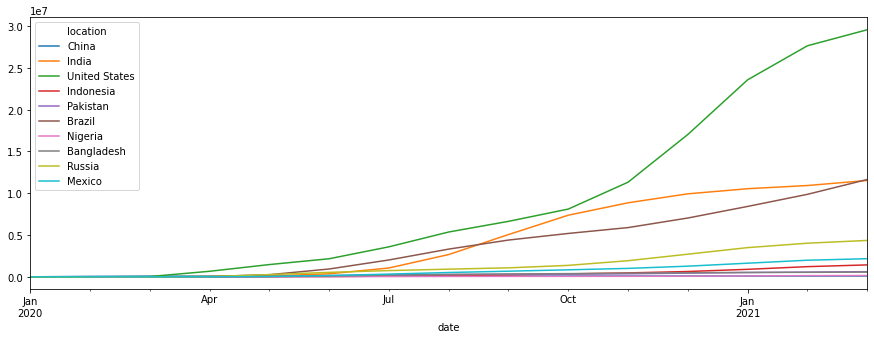

In [12]:
countries.resample('M').mean().plot(figsize = (15,5))

### Map of total cases by country

The new dataframe contains total cases by grouped by country.

In [13]:
totals = subset1[['total_cases', 'location']].groupby('location').sum().reset_index()

colors = 9
cmap = 'Blues'
figsize = (16, 10)
year = '2019'
cols = ['Country Name', year]

In order to create a map in geopandas, I imported a shapefile from Natural Earth with polygons for each country.

In [14]:
test = 'ne_10m_admin_0_countries.shp'

gpd.read_file(test)

gdf = gpd.read_file('ne_10m_admin_0_countries.shp')[['SOVEREIGNT', 'geometry']].to_crs('+proj=robin')
gdf.sample(5)

,SOVEREIGNT,geometry
124,Burundi,"POLYGON ((2885636.262 -256751.717, 2882472.864..."
156,Belize,"MULTIPOLYGON (((-8325643.664 1753221.403, -832..."
175,Fiji,"MULTIPOLYGON (((-16807563.034 -1729370.086, -1..."
137,Colombia,"MULTIPOLYGON (((-7446457.988 153402.447, -7444..."
93,Iran,"MULTIPOLYGON (((3908412.382 4238074.506, 39087..."


The columns SOVEREIGNT and location in respective datasets both contain the name of the country. The next step is to perform a merge of the two datasets.

In [15]:
merged = gdf.merge(totals, left_on= 'SOVEREIGNT', right_on = 'location')

merged.head()

,SOVEREIGNT,geometry,location,total_cases
0,Indonesia,"MULTIPOLYGON (((11108970.260 445285.130, 11108...",Indonesia,166994097.0
1,Malaysia,"MULTIPOLYGON (((11108970.260 445285.130, 11108...",Malaysia,28672066.0
2,Chile,"MULTIPOLYGON (((-6477059.899 -1872360.838, -64...",Chile,162925591.0
3,Bolivia,"POLYGON ((-6477059.899 -1872360.838, -6477072....",Bolivia,43103860.0
4,Peru,"MULTIPOLYGON (((-6477059.899 -1872360.838, -64...",Peru,256326552.0


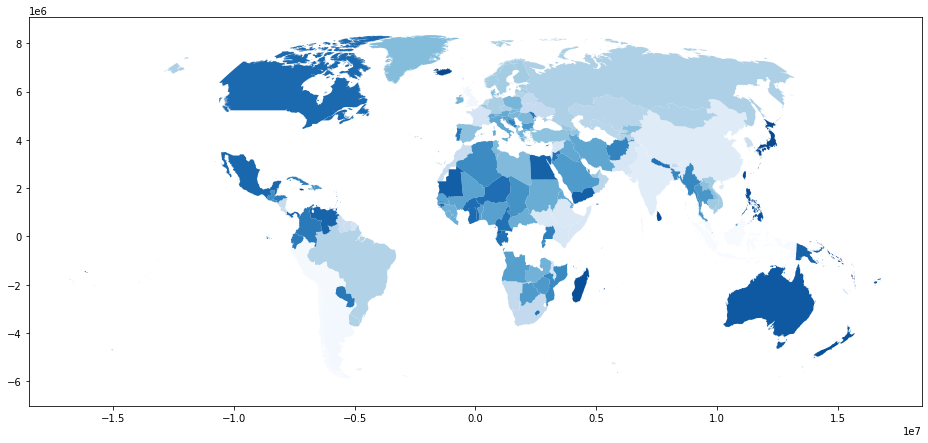

In [16]:
ax = merged.dropna().plot(cmap=cmap, figsize = figsize, scheme = 'equal_interval', k = colors, legend = True)

### Analysis of Countries with Correlations

Not all the values from this dataset are actual countries, some are continents or regions. From this list the countries with the highest number of cases over the course of the pandemic are: 

- United States
- India
- Brazil
- Russia
- France
- United Kingdom
- Spain
- Italy
- Turkey
- Colombia


In [32]:
#totals.sort_values('total_cases', ascending = False).head(20)

In [35]:
top10 = ['United States', 'India', 'Brazil', 'Russia', 'France', 'United Kingdom', 'Spain', 'Italy', 'Turkey', 'Colombia']

In [37]:
top_ten = df[df['location'].isin(top10)]

In [44]:
table_ten = pd.pivot_table(top_ten, values='total_cases', index='date',
                    columns=['location'], aggfunc=np.sum)

In [45]:
table_ten.head()

location,Brazil,Colombia,France,India,Italy,Russia,Spain,Turkey,United Kingdom,United States
date,,,,,,,,,,
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-01-24,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2020-01-25,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2020-01-26,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0


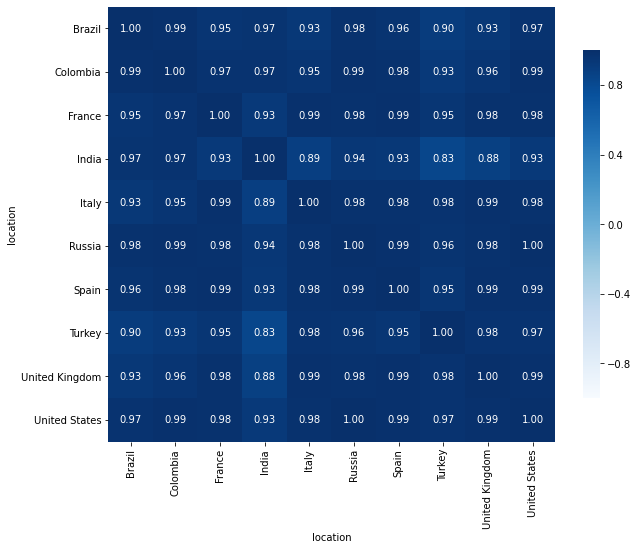

In [64]:
fig, ax = plt.subplots(figsize=(10, 8))
# mask
#mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
#mask = mask[1:, :-1]
corr = table_ten.corr()
# plot heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

It looks like the cases of all of the countries are very correlated.

### PCA

Let's try looking at the dataset where the columns are daily total cases.

In [70]:
table_ten = table_ten.reset_index()

location,index,date,Brazil,Colombia,France,India,Italy,Russia,Spain,Turkey,United Kingdom,United States
0,0,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2,2020-01-24,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,3,2020-01-25,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,4,2020-01-26,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [93]:
table_10 = pd.pivot_table(table_ten, values=['Brazil', 'Colombia', 'France', 'India', 'Italy', 'Russia', 'Spain', 'Turkey', 'United Kingdom', 'United States'], index=None,
                    columns=['date'], aggfunc=np.sum)

We have now transformed the dataset into a multidimensional dataset where each day is a column.


In [94]:
table_10.shape

(10, 435)

This is the last day on which data was collected. I'm setting this day to my target variable for the purpose of PCA.

In [95]:
table_10.columns[-1]

'2021-03-31'

In [96]:
target = table_10['2021-03-31']

In [97]:
table_10 = table_10.drop('2021-03-31',axis=1)

We are looking to apply PCA.

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
# Load the data
X = table_10.values
y = target
# Z-score the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# The PCA model
pca = PCA(n_components=2) # estimate only 2 PCs
X_new = pca.fit_transform(X) # project the original data into the PCA space

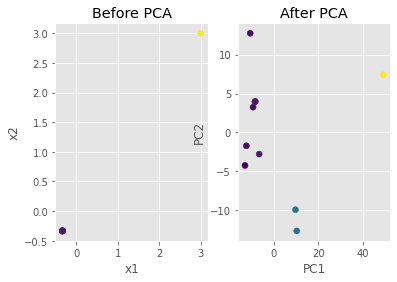

In [100]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(X[:,0], X[:,1], c=y)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(X_new[:,0], X_new[:,1], c=y)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()

In [104]:
def biplot(score, coeff , y):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(10,8), dpi=100)
    classes = np.unique(y)
    colors = ['g','r','y']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)
    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

IndexError: list index out of range

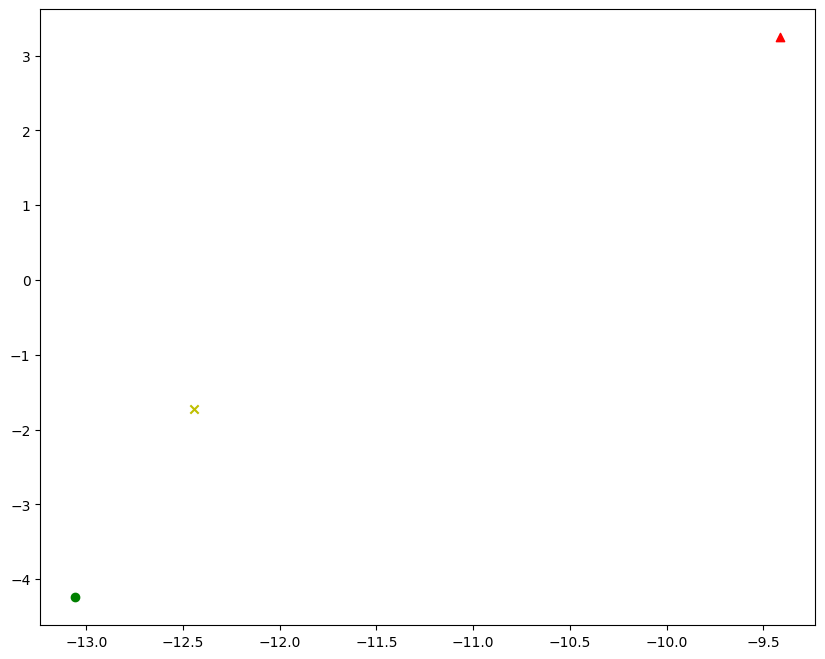

In [105]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) # reset ggplot style
# Call the biplot function for only the first 2 PCs
biplot(X_new[:,0:2], np.transpose(pca.components_[0:2, :]), y)
plt.show()

### Total covid cases computed as a percentage



In [17]:
tables = pd.pivot_table(subset1, values='total_cases',
                    columns=['location'], aggfunc=np.sum)

table_df = pd.DataFrame(tables)

Perhaps looking at the total cases by continent would be interesting.

In [18]:
table_df[['Asia', 'Europe', 'Africa', 'Australia', 'South America', 'North America']]

location,Asia,Europe,Africa,Australia,South America,North America
total_cases,4.246183e+09,4.642085e+09,623609882.0,7693075.0,3.034671e+09,4.807592e+09


In [19]:
countries_list  =['China', 'India', 'United States', 'Indonesia', 'Pakistan', 'Brazil', 'Nigeria', 'Bangladesh', 'Russia', 'Mexico']
total_largest  = totals[totals.location.isin(countries_list)]

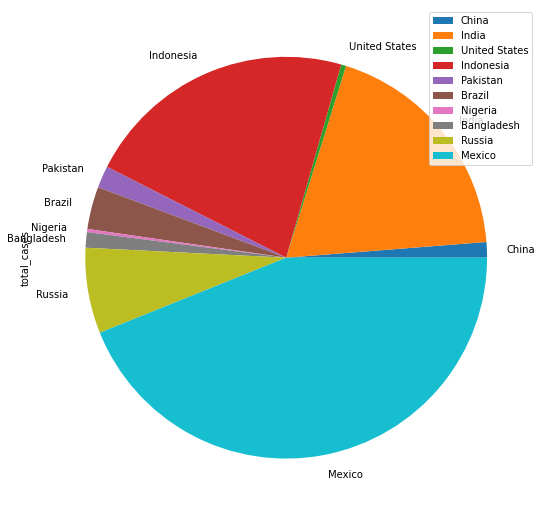

In [20]:
labels = countries_list
total_largest.plot.pie(y = 'total_cases', labels = labels, figsize = (9,12))